<a href="https://colab.research.google.com/github/szymbor2/atms597_project6/blob/master/project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ATMS 597 Project 6 Group D



<b> Set Working Directory </b>

In [0]:
YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project6/' # Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Project6/' # Michael


<b> Import libraries</b>

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set(font_scale = 1.5)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Processing

<b> Import Data </b>

In [0]:
gfs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)

hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly_obs.index = hourly_obs.index + pd.DateOffset(hours=12)

daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
daily_obs.index = daily_obs.index + pd.DateOffset(hours=12)

gfs_sfc = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_sfc.index = gfs_sfc.index + pd.DateOffset(days=1)

gfs_prof = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_prof.index = gfs_prof.index + pd.DateOffset(days=1)

<b> Merge Datasets </b>

In [0]:
features = pd.merge(daily_obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly_obs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features = pd.merge(features, gfs_prof.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

<b> Other stuff </b>

In [0]:
# Add year, month, day as integers
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

# Filter the predictors
predictors = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# For plotting
test_dates = np.array(features.query('year == 2019')['Date'])

# Linear Regression

## Maximum Temperature

### Training Model

In [0]:
# Training
train_verification_tmax = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification_tmax = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

lr_tmax_vars = ['TMAX','TMIN','tmpc','dwpc','Avg DWPDEP(C)','Avg LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Avg 925hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)','Max 925hPa TMPC',
                     'Max 850hPa TMPC','Min 925hPa TMPC','Min 850hPa TMPC', 'Min 850hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max DWPDEP(C)','wspd','Avg 250hPa DWPDEP(C)',
                     'Avg 925hPa TMPC']

lr_train_vars_tmax = predictors.query('year < 2019')[lr_tmax_vars] 
lr_test_vars_tmax = predictors.query('year == 2019')[lr_tmax_vars]

# Fit the model
lrmax = LinearRegression(fit_intercept=True)
lrmax.fit(lr_train_vars_tmax, train_verification_tmax);

### RMSE

In [10]:
lr_predictions_tmax = lrmax.predict(lr_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, lr_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.94 degrees C.


### Plot

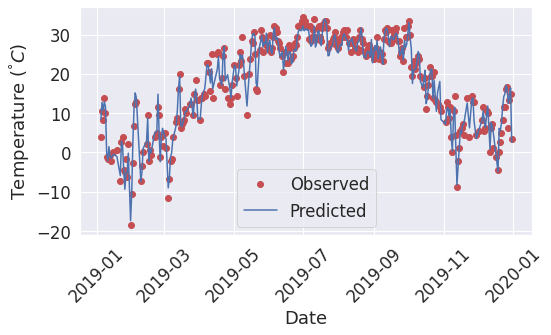

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

### Training Model

In [0]:
# Training
train_verification_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

lr_tmin_vars = ['TMAX','TMIN','tmpc','dwpc','wdir','Avg DWPDEP(C)','Avg LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Avg 925hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)',
                'Max 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 500hPa HGT(m)','Max 925hPa TMPC','Max 850hPa TMPC','Min 925hPa TMPC','Min 850hPa TMPC','wspd','Min 850hPa WSPD(m/s)',
                'Min 925hPa WSPD(m/s)']

lr_train_vars_tmin = predictors.query('year < 2019')[lr_tmin_vars] 
lr_test_vars_tmin = predictors.query('year == 2019')[lr_tmin_vars]

# Fit the model
lrmin = LinearRegression(fit_intercept=True)
lrmin.fit(lr_train_vars_tmin, train_verification_tmin);

### RMSE

In [13]:
lr_predictions_tmin = lrmin.predict(lr_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, lr_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.08 degrees C.


### Plot

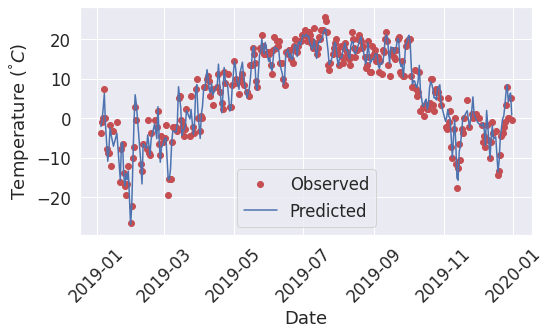

In [14]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Max Wind

### Training Model

In [0]:
# Training
train_verification_wind = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification_wind = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

lr_wind_vars = ['WMAX','tmpc','wspd','mslp','Avg DWPDEP(C)','Avg MCLD(%)','Max MCLD(%)','Avg HCLD(%)','Min HCLD(%)','Min PRES(hPa)','Max 925hPa WSPD(m/s)',
                'Avg 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Min 250hPa HGT(m)','Max 500hPa HGT(m)','Max 925hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 850hPa WSPD(m/s)',
                'Min 850hPa WSPD(m/s)','Max 500hPa WSPD(m/s)','Min 500hPa WSPD(m/s)','Min 925hPa TMPC','Max 850hPa TMPC','month',
                'Max 700hPa DWPDEP(C)','Max 700hPa HGT(m)','Avg 500hPa TMPC','Max 700hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)'] 

lr_train_vars_wind = predictors.query('year < 2019')[lr_wind_vars] 
lr_test_vars_wind = predictors.query('year == 2019')[lr_wind_vars]

# Fit the model
lrwind = LinearRegression(fit_intercept=True)
lrwind.fit(lr_train_vars_wind, train_verification_wind);

### RMSE

In [16]:
lr_predictions_wind = lrwind.predict(lr_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, lr_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.73 m/s.


### Plot

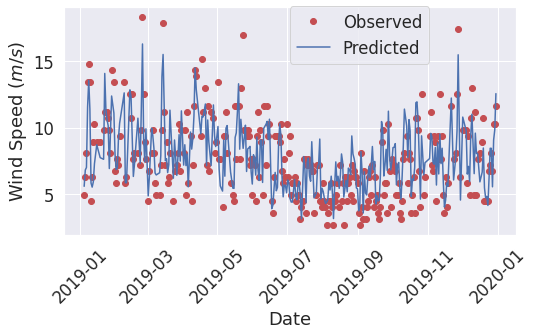

In [17]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.5, 0.75])
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

## Precipitation

### Training Model

In [0]:
# Training
train_verification_prcp = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification_prcp = np.array(features.query('year == 2019')['Daily Precip (mm)'])

lr_prcp_vars = ['RTOT','TMIN','skct','wdir','wspd','Min DWPDEP(C)','Avg MCLD(%)','Max MCLD(%)','Avg HCLD(%)','Max PRES(hPa)','Max 850hPa DWPDEP(C)','Min 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa HGT(m)','Min 500hPa HGT(m)','Max 925hPa TMPC','Min 925hPa TMPC','WMAX','Max PRES(hPa)','tmpc','mslp',
                            'Avg 700hPa DWPDEP(C)','Max 700hPa WSPD(m/s)']

lr_train_vars_prcp = predictors.query('year < 2019')[lr_prcp_vars] 
lr_test_vars_prcp = predictors.query('year == 2019')[lr_prcp_vars]

# Fit the model
lrprcp = LinearRegression(fit_intercept=True)
lrprcp.fit(lr_train_vars_prcp, train_verification_prcp);

### RMSE

In [19]:
lr_predictions_prcp = lrprcp.predict(lr_test_vars_prcp)
lr_predictions_prcp = np.array([prcp if prcp > 0.0 else 0.0 for prcp in lr_predictions_prcp]) # We get some negative precip predictions! Set to zero
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, lr_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.24 mm.


### Plot

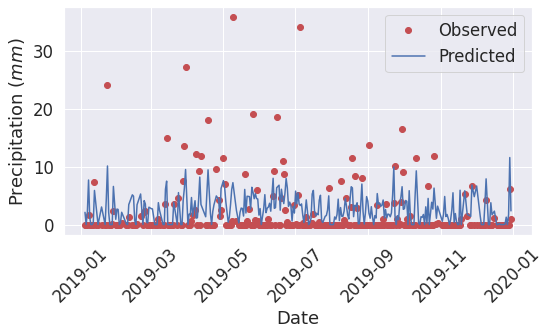

In [20]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, lr_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Random Forest Regression

## Maximum Temperature

### Training Model

In [0]:
# Training
rf_tmax_vars  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']

rf_train_vars_tmax = predictors.query('year < 2019')[rf_tmax_vars] 
rf_test_vars_tmax = predictors.query('year == 2019')[rf_tmax_vars]

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmax.fit(rf_train_vars_tmax, train_verification_tmax);

### RMSE

In [22]:
rf_predictions_tmax = rfmax.predict(rf_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, rf_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


### Plot

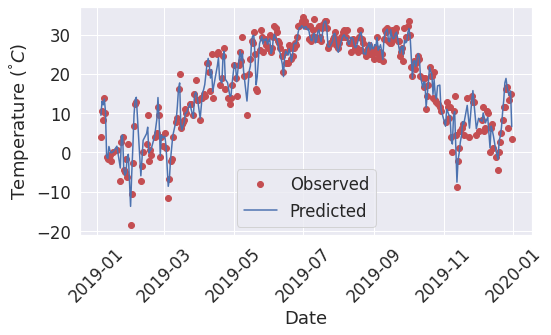

In [23]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

### Training Model

In [0]:
# Training
rf_tmin_vars = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 

rf_train_vars_tmin = predictors.query('year < 2019')[rf_tmin_vars] 
rf_test_vars_tmin = predictors.query('year == 2019')[rf_tmin_vars]

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmin = rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmin.fit(rf_train_vars_tmin, train_verification_tmin);

### RMSE

In [25]:
rf_predictions_tmin = rfmin.predict(rf_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, rf_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.11 degrees C.


### Plot

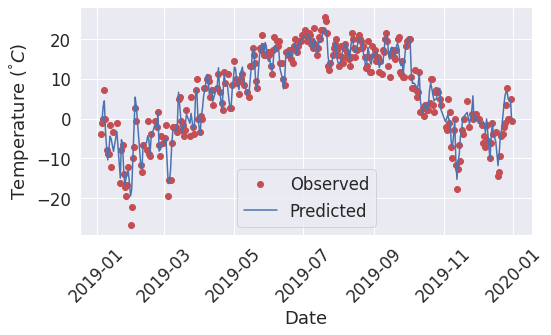

In [26]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Maximum Wind

### Training Model

In [0]:
# Training
rf_train_vars_wind = predictors.query('year < 2019').to_numpy()  # Use all available predictors
rf_test_vars_wind = predictors.query('year == 2019').to_numpy()

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfwind.fit(rf_train_vars_wind, train_verification_wind);

### RMSE

In [28]:
rf_predictions_wind = rfwind.predict(rf_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, rf_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.69 m/s.


### Plot

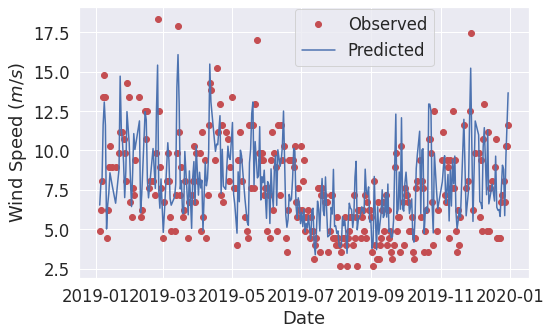

In [29]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

## Precipitation

### Training Model

In [0]:
# Training
rf_prcp_vars = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']

rf_train_vars_prcp = predictors.query('year < 2019')[rf_prcp_vars] 
rf_test_vars_prcp = predictors.query('year == 2019')[rf_prcp_vars]

# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfprcp = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)
rfprcp.fit(rf_train_vars_prcp, train_verification_prcp);

### RMSE

In [31]:
rf_predictions_prcp = rfprcp.predict(rf_test_vars_prcp)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, rf_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


### Plot

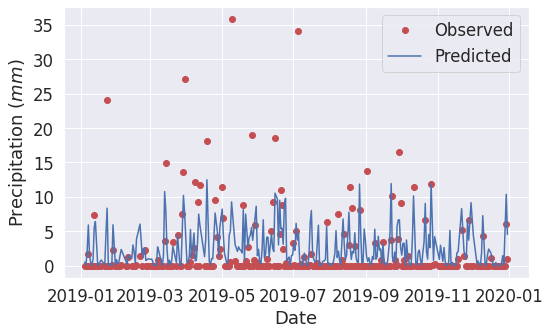

In [32]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Deep Neural Network

<b> Import libraries </b>

In [45]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import datetime, os
from sklearn.linear_model import LogisticRegression
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

# Set index as Date
features.set_index('Date', inplace=True) # RUN ONCE or else it doesn't like to run this cell

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


KeyError: ignored

<b> Train features </b>

In [0]:
# Set features as train_features to create new df
train_features = predictors

# Standardize features
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std

<b> Build Model </b>


In [0]:
# Build Model
def build_model():
    model = keras.Sequential([
      Dense(20, activation=tf.nn.relu, input_shape=[len(train_features.values[0])]),
        Dense(1)
    ])

#    model = keras.Sequential([
#      Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
#      Dense(6, activation=tf.nn.relu),
#        Dense(1)
#    ])

    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, 
                                                 beta_2=0.999, epsilon=1e-07, amsgrad=False), # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse',
                  metrics=['mae', 'mse'])

    return model

## TMAX

### Training Label

In [0]:
# Train labels
train_labels = train_features['TMAX']

### Train Model

In [50]:
model = build_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_features.values, train_labels.values, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.7550 - mae: 0.6472 - mse: 0.7559 - val_loss: 0.4389 - val_mae: 0.4795 - val_mse: 0.3796
Epoch 2/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.2337 - mae: 0.3771 - mse: 0.2338 - val_loss: 0.2454 - val_mae: 0.3792 - val_mse: 0.2263
Epoch 3/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.1477 - mae: 0.3016 - mse: 0.1478 - val_loss: 0.1570 - val_mae: 0.3120 - val_mse: 0.1505
Epoch 4/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.1091 - mae: 0.2585 - mse: 0.1091 - val_loss: 0.1225 - val_mae: 0.2740 - val_mse: 0.1168
Epoch 5/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0859 - mae: 0.2289 - mse: 0.0858 - val_loss: 0.1025 - val_mae: 0.2469 - val_mse: 0.0951
Epoch 6/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0718 - mae: 0.2095 - mse: 0.0717 - val_loss: 0.0903 - val_mae: 0.2335 - val_mse: 0.0843
Epoch 7/1000
91/

### RMSE

In [51]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 0.004


## TMIN

### Training labels

In [0]:
train_labels = train_features['TMIN']

### Train Model

In [53]:
model = build_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_features.values, train_labels.values, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.3729 - mae: 0.4652 - mse: 0.3731 - val_loss: 0.2411 - val_mae: 0.3702 - val_mse: 0.2181
Epoch 2/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.1495 - mae: 0.3029 - mse: 0.1496 - val_loss: 0.1560 - val_mae: 0.2897 - val_mse: 0.1355
Epoch 3/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.1021 - mae: 0.2499 - mse: 0.1021 - val_loss: 0.1169 - val_mae: 0.2470 - val_mse: 0.0992
Epoch 4/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0759 - mae: 0.2169 - mse: 0.0760 - val_loss: 0.0915 - val_mae: 0.2122 - val_mse: 0.0766
Epoch 5/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0586 - mae: 0.1885 - mse: 0.0587 - val_loss: 0.0723 - val_mae: 0.1906 - val_mse: 0.0627
Epoch 6/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0474 - mae: 0.1695 - mse: 0.0474 - val_loss: 0.0635 - val_mae: 0.1786 - val_mse: 0.0552
Epoch 7/1000
91/

### RMSE

In [54]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 0.012


## WMAX

### Training labels

In [0]:
train_labels = train_features['WMAX']

### Train Models

In [56]:
model = build_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_features.values, train_labels.values, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/1000
91/91 [==============================] - 0s 3ms/step - loss: 1.0330 - mae: 0.7856 - mse: 1.0343 - val_loss: 0.5747 - val_mae: 0.5920 - val_mse: 0.5650
Epoch 2/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.3839 - mae: 0.4843 - mse: 0.3843 - val_loss: 0.3714 - val_mae: 0.4805 - val_mse: 0.3593
Epoch 3/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.2277 - mae: 0.3719 - mse: 0.2278 - val_loss: 0.2365 - val_mae: 0.3796 - val_mse: 0.2185
Epoch 4/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.1350 - mae: 0.2859 - mse: 0.1351 - val_loss: 0.1430 - val_mae: 0.2926 - val_mse: 0.1321
Epoch 5/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0868 - mae: 0.2294 - mse: 0.0869 - val_loss: 0.1022 - val_mae: 0.2433 - val_mse: 0.0923
Epoch 6/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0613 - mae: 0.1917 - mse: 0.0614 - val_loss: 0.0721 - val_mae: 0.2040 - val_mse: 0.0654
Epoch 7/1000
91/

### RMSE

In [57]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 0.011


## RTOT

### Training labels

In [0]:
train_labels = train_features['RTOT']

### Train Models

In [59]:
model = build_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_features.values, train_labels.values, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Epoch 1/1000
91/91 [==============================] - 0s 3ms/step - loss: 1.1840 - mae: 0.6878 - mse: 1.1851 - val_loss: 0.6655 - val_mae: 0.5645 - val_mse: 0.6914
Epoch 2/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.6590 - mae: 0.5087 - mse: 0.6597 - val_loss: 0.4561 - val_mae: 0.4764 - val_mse: 0.4732
Epoch 3/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.4091 - mae: 0.4037 - mse: 0.4095 - val_loss: 0.2662 - val_mae: 0.3751 - val_mse: 0.2781
Epoch 4/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.2248 - mae: 0.3086 - mse: 0.2250 - val_loss: 0.1433 - val_mae: 0.2746 - val_mse: 0.1485
Epoch 5/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.1211 - mae: 0.2391 - mse: 0.1211 - val_loss: 0.0990 - val_mae: 0.2306 - val_mse: 0.0991
Epoch 6/1000
91/91 [==============================] - 0s 2ms/step - loss: 0.0789 - mae: 0.2006 - mse: 0.0790 - val_loss: 0.0822 - val_mae: 0.2069 - val_mse: 0.0814
Epoch 7/1000
91/

### RMSE

In [60]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 0.004
